# Implementação em CUDA Pytorch Difusão de Calor 2D

In [9]:
import torch as th
import torch.nn.functional as F
import numpy as np

th.set_num_threads(8)

def rodarSimulacaoPytorch(N, niter, dt, save=10, lmbda=0.04175):
    """
    * N : numero de pontos discretização em x e y
    * duracao : em segundos da simulacao da difusao
    * lmbda : lambda predefido para garantir estabilidade numérica 
    igual à 0.04175 baseado no item 1
    * save : numero de 'snapshots' para salvar  

    O numero de iteracoes é calculado baseado na duracao
    """
    k = 0.835 #K alumínio = 1/alfa^2
    ds = 10./(N-1) # 10 cm / N-1 pontos discretização espaço 
    tplaca = np.zeros((N, N)) # temperatura da placa em tn e tn+1 : 
    # condições de contorno iniciais no tempo 0 
    # extremidades da placa 
    tplaca[:,  0] = 100. # esquerda 
    tplaca[:, -1] = 50. # direita
    # topo e base da placa assumindo temperatura = 0
    kernel = np.array([[0, 1, 0],[1, -4, 1],[0, 1, 0]]) # diferenciador convolucional        
    nsave = int(niter/save) # step de iteracoes para salvar 'snapshot'
    snapshots = np.zeros((save+1, N, N)) # 'filme' das iteracoes
    isnap = 0 # indice para salvar 'snapshots' das iteracoes        

    # pytorch wrapping
    kernel = th.tensor(kernel, dtype=th.float32)
    kernel = kernel.unsqueeze(0).unsqueeze(0)     # pytorch format for conv2d
    tplaca = th.tensor(tplaca, dtype=th.float32)
    tplaca = tplaca.unsqueeze(0).unsqueeze(0)  
    snapshots = th.tensor(snapshots, dtype=th.float32)

    # send to cuda 
    #     kernel = kernel.to("cuda")
    #     tplace = tplace.to("cuda")
    #     snapshots = snapshots.to("cuda")

    for n in range(niter): # marcha
        # calcula tn+1 em funcao de f(tn) 
        tplaca[0, 0, 1:-1, 1:-1] = lmbda*F.conv2d(tplaca, kernel) + tplaca[0, 0, 1:-1, 1:-1]

        if n%nsave==0:
            snapshots[isnap] = tplaca.squeeze(0).squeeze(0)
            isnap += 1 # p/ próximo 'frame' do 'filme'

    # imprime um resumo de alguns parâmetros
    #print('Dt: {:.3g} numero de Iteracoes: {:5d} '.format(dt, niter))

    # salva o último
    snapshots[-1] = tplaca.squeeze(0).squeeze(0)
    # retorna o 'filme' de snapshots, e o intervalo em x    
    return snapshots, ds

In [11]:
%%time
snapshots, ds = rodarSimulacao(1000, 1000, 0.1)

CPU times: user 2min 48s, sys: 19.6 s, total: 3min 7s
Wall time: 24.4 s


In [55]:
snapshots = snapshots.data.numpy()

In [56]:
%matplotlib inline

In [57]:
from matplotlib import pyplot as plt

In [59]:
len(snapshots)

11

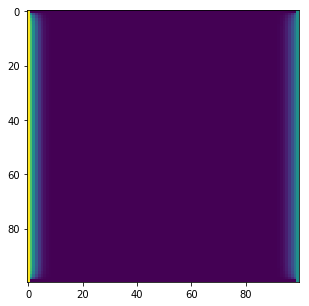

In [61]:
plt.figure(figsize=(15,5))
plt.imshow(snapshots[10])